The purpose of this notebook is to load object level feature similarity matrices for different features and generate distributions of looking times as a function of similarity to target vs. distractors. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import visual_search_load
import visual_search_preproc
import scipy.interpolate
from matplotlib import animation, rc
from IPython.display import HTML
import imageio
from colorspacious import cspace_converter
from scipy.io import loadmat
from mpl_toolkits import mplot3d
import pickle
from time import perf_counter
from scipy import stats
import sys
import visual_search_rsa
import os
import pingouin as pg

UTILS_DIR = 'FC_geodesic/utils/distance_FC'
sys.path.insert(0, UTILS_DIR)
from distance_FC import distance_FC

### Load and format similarity data.

In [2]:
data_direc = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchGazeData/'
gaze_objects = pd.read_csv(data_direc + 'gaze_raw.csv', index_col=False)

## Exclude assistant trials. 
gaze_objects = gaze_objects[gaze_objects['condition'] == 'No'].reset_index(drop=True)

## List all participants.
indexes = np.unique(gaze_objects['participant'].values, return_index=True)[1]
all_participants = [gaze_objects['participant'].values[index] for index in sorted(indexes)]

## Load object locations. 
locations = pd.read_csv(data_direc + 'location/location_all_objects.csv')

/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
## Load different similarity metrics.
shape = pickle.load(open(data_direc + 'shape/similarity_l2.pickle', "rb" ))
# shape = pickle.load(open(data_direc + 'shape/similarity_spearman.pickle', "rb" ))

color = pickle.load(open(data_direc + 'color/similarity_l2.pickle', "rb" ))
# color = pickle.load(open(data_direc + 'color/similarity_spearman.pickle', "rb" ))

## For VGG embeddings, select layer  
# layer = 'block5_pool'
layer = 'block5_pool'
# vgg = pickle.load(open(data_direc + '/vgg/similarity/' + layer + '_euclidean_distance.pickle', "rb"))
# vgg = pickle.load(open(data_direc + '/vgg/similarity/' + layer + '_pearson_distance.pickle', "rb"))
vgg = pickle.load(open(data_direc + '/vgg/similarity/' + layer + '_spearman_distance.pickle', "rb"))

unique_objects = shape['unique_objects']
n_objects = unique_objects.shape[0]

### Z-score and shift around 0 to get a reward proxy. 

In [4]:
shape_zscored = stats.zscore(shape['similarity_matrix'][np.triu_indices(n_objects)])
shape_reward = np.zeros((n_objects,n_objects))
shape_reward[np.triu_indices(shape_reward.shape[0])] = shape_zscored - np.min(shape_zscored)

color_zscored = stats.zscore(color['similarity_matrix'][np.triu_indices(n_objects)])
color_reward = np.zeros((n_objects,n_objects))
color_reward[np.triu_indices(color_reward.shape[0])] = color_zscored - np.min(color_zscored)

vgg_zscored = stats.zscore(vgg['similarity_matrix'][np.triu_indices(n_objects)])
vgg_reward = np.zeros((n_objects,n_objects))
vgg_reward[np.triu_indices(vgg_reward.shape[0])] = vgg_zscored - np.min(vgg_zscored)

### Make dataframes. 

In [5]:
use_raw = 0

if use_raw:
    shape_similarity_df = pd.DataFrame(shape['similarity_matrix'] + shape['similarity_matrix'].T)
    color_similarity_df = pd.DataFrame(color['similarity_matrix'] + color['similarity_matrix'].T) 
    vgg_similarity_df = pd.DataFrame(vgg['similarity_matrix'] + vgg['similarity_matrix'].T) 
else:
    shape_similarity_df = pd.DataFrame(shape_reward + shape_reward.T)
    color_similarity_df = pd.DataFrame(color_reward + color_reward.T)
    vgg_similarity_df = pd.DataFrame(vgg_reward + vgg_reward.T)

### Select similarity matrix for analysis.

In [6]:
feature = 'VGG'
if feature == 'Shape': similarity_df = shape_similarity_df 
if feature == 'Color': similarity_df = color_similarity_df
if feature == 'VGG': similarity_df = vgg_similarity_df
if feature == 'Color (A)': similarity_df = color_A_similarity_df
if feature == 'Color (B)': similarity_df = color_B_similarity_df
if feature == 'Shape_color': similarity_df = (shape_similarity_df + color_similarity_df) / 2
similarity_df.columns = unique_objects

### Does similarity to target predict gaze? 

This analysis plots two distributions of shape similarities for fixated objects, across all samples and all participants:
* Similarity of the fixated object to the target
* Similarity of the fixated object to the average similarity of distractors

If shape similarity to target drives gaze, we would expect to see the a shift in the target similarity distribution to the left. That is, fixated objects are more similar to the target than to non-targets. 

#### Prep dataframe. 

In [7]:
## Subset gaze samples for valid objects. 
df = gaze_objects[gaze_objects['valid'] == 1]

## Exclude gaze samples in which people are looking at the target. 
df = df[df['object'] != df['target']] 

## Index gaze object label into similarity matrix.
# This gives the similarity of the object being looked at to all possible targets. 
df_sim = similarity_df[df['object']].T 
df_sim.columns = unique_objects

## Reset indices. 
df = df.reset_index(drop=True)
df_sim = df_sim.reset_index(drop=True)

## Make a copy of the similarity matrix data frame which includes object column.
sim_df_copy = similarity_df.copy()
sim_df_copy.insert(0,'object',unique_objects)

## Retrieve similarity between a particular object and a target. 
o = 'Mug'
t = 'Book 12'

#### Record similarity to target. 

In [8]:
n_samples = len(df)
sim_to_target = np.zeros(n_samples)

# Loop thru all object labels and identify times when this object was the target.
for t in list(unique_objects):
    # Find sample indices where this object was the target.
    idx, = np.where(np.isin(df['target'], t))
    # Record similarity to target.
    sim_to_target[idx] = df_sim.iloc[idx][t]
        
df['sim_to_target'] = sim_to_target

#### Record similarity to non-targets. 

In [9]:
all_scenes = np.unique(df['scene'].values)
sim_to_non_targets = np.zeros((n_samples,115))*np.nan

# Loop thru all scenes.
for s in all_scenes:
    
    # Get scene properties.
    target_in_scene = visual_search_load.get_target_object(data_direc + 'scenes/', s)
    objects_in_scene = visual_search_load.get_all_objects(data_direc + 'scenes/', s)
    non_targets_in_scene = objects_in_scene[1:-1]
    
    # Find sample indices where we were in this scene.
    idx = df.index[df['scene'] == s].tolist()
    
    # This is the similarity of the object with index idx in the df and all the non-targets. 
    x = df_sim.iloc[idx][non_targets_in_scene]
    l, w = x.shape
    sim_to_non_targets[idx,0:w] = np.array(df_sim.iloc[idx][non_targets_in_scene])
    
sim_non_targ = sim_to_non_targets.flatten()
sim_non_targ = sim_non_targ[~np.isnan(sim_non_targ)]

## Take average similarity across non targets in the scene.
sim_non_targ_avg = np.nanmean(sim_to_non_targets, axis=1)

## Get all distractor similarities without averaging. 
sim_to_non_targets_all = sim_to_non_targets[~np.isnan(sim_to_non_targets)].flatten() 

#### Plot gaze distributions as a function of similarity.

/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


mean target: 1.2932356070688689
SD target: 0.8494848423722837
mean non target: 1.3621107486547936
SD non target: 0.36317316256229604


Ttest_relResult(statistic=-51.512393988892605, pvalue=0.0)

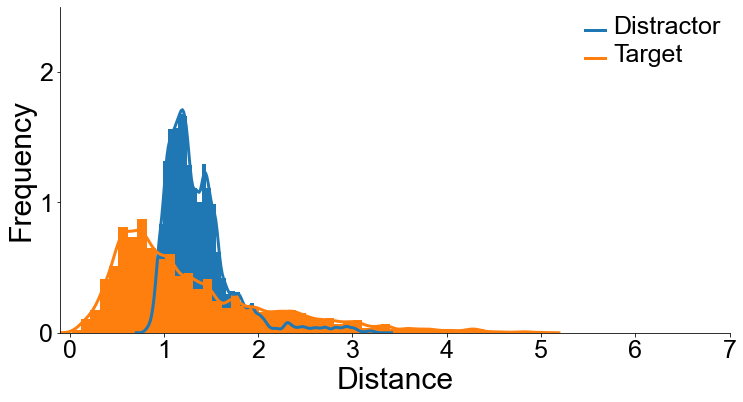

In [10]:
## Exclude gaze samples in which people are looking at the target. 
sim_targ = df['sim_to_target'].values

bins = np.arange(0,10000,200)

# flatui = ["#9b59b6", "#3498db", "#e74c3c", "#34495e", "#2ecc71"]
flatui = ['#34495e', "#2ecc71"]
purples = ["#D8BFD8", "#9b59b6"]
blues = ["#c1e1ec", "#3498db"]
reds = ["#edaea6", '#e74c3c']
greens = ["#addd8e", "#61a96a"]
greys = ['#e3e3e3','#bebebe']

fig, ax = plt.subplots(figsize=(12,6))
sns.set_palette(sns.color_palette(greys))
sns.distplot(sim_non_targ_avg, hist=True, 
             kde_kws={"lw": 3, "label": "Distractor"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 0, "alpha": 1},
             ax=ax)
sns.distplot(sim_targ, hist=True,
             kde_kws={"lw": 3, "label": "Target"},
             hist_kws={"histtype": "stepfilled", "linewidth": 0, "alpha": 1},
             ax=ax)
ax.set_yticks([0, 1, 2])
# plt.tick_params(bottom=False)
# plt.title('Layer: ' + layer, fontsize=40)    
plt.legend(frameon=False)
ax.set_xlim((-0.1, 7))
ax.set_ylim((0,2.5))
plt.setp(ax.get_xticklabels(), fontsize=25)
plt.setp(ax.get_yticklabels(), fontsize=25)
plt.setp(ax.get_legend().get_texts(), fontsize=25) 
plt.xlabel('Distance', fontsize=30);
plt.ylabel('Frequency', fontsize=30);
sns.despine();
sns.set_style('white');

print('mean target: ' + str(np.mean(sim_targ)))
print('SD target: ' + str(np.std(sim_targ)))
print('mean non target: ' + str(np.mean(sim_non_targ_avg)))
print('SD non target: ' + str(np.std(sim_non_targ_avg)))
stats.ttest_rel(sim_targ, sim_non_targ_avg)

In [11]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

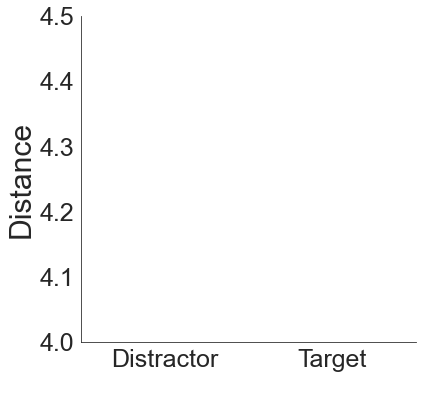

In [12]:
n = sim_targ.shape[0]
d = {'target': np.concatenate([np.zeros(n), np.ones(n)]), 'distance': np.concatenate([sim_non_targ_avg, sim_targ])}
df_bar = pd.DataFrame(d)

fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x="target", y="distance", data=df_bar, ax=ax)
# ax.set_ylim((0.8,1.3)) # shape
# ax.set_ylim((1.5,2)) # color
# ax.set_ylim((1.2,1.7)) # shape and color
# ax.set_ylim((1,1.5)) # vgg block5
ax.set_ylim((4,4.5)) # vgg fc2
plt.setp(ax.get_xticklabels(), fontsize=25)
plt.setp(ax.get_yticklabels(), fontsize=25)
ax.set_xticklabels(['Distractor', 'Target'])
change_width(ax, 0.5);
plt.xlabel(' ', fontsize=30);
plt.ylabel('Distance', fontsize=30);
sns.despine();
sns.set_style('white');

if feature == 'VGG': 
    df_bar['sample'] = np.arange(len(df_bar))+1
    df_bar['layer'] = layer
    df_bar.to_csv('distance_target_distractor_' + layer + '.csv', index=False)

In [31]:
if feature == 'VGG':

    layer_1 = pd.read_csv('distance_target_distractor_block5_pool.csv')
    layer_2 = pd.read_csv('distance_target_distractor_fc2.csv')
    df_layer_interaction = pd.concat([layer_1, layer_2])

    aov = pg.anova(dv='distance', between=['layer', 'target'], data=df_layer_interaction)
    pg.print_table(aov)


ANOVA SUMMARY

Source                   SS       DF           MS            F    p-unc      np2
--------------  -----------  -------  -----------  -----------  -------  -------
layer           2778182.033        1  2778182.033  6684582.044    0.000    0.835
target             1720.809        1     1720.809     4140.438    0.000    0.003
layer * target        3.593        1        3.593        8.645    0.003    0.000
Residual         549195.937  1321420        0.416      nan      nan      nan



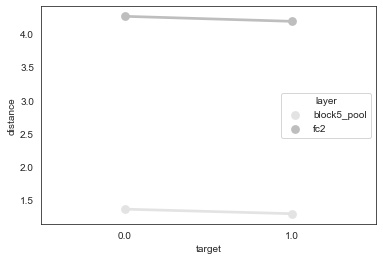

In [32]:
ax = sns.pointplot(x="target", y="distance", hue="layer", data=df_layer_interaction)

In [33]:
x = df_layer_interaction[(df_layer_interaction['layer'] == 'block5_pool') & (df_layer_interaction['target'] == 0)]
y = df_layer_interaction[(df_layer_interaction['layer'] == 'block5_pool') & (df_layer_interaction['target'] == 1)]
abs(x['distance'].mean() - y['distance'].mean())  

0.06887514158567498

In [34]:
x = df_layer_interaction[(df_layer_interaction['layer'] == 'fc2') & (df_layer_interaction['target'] == 0)]
y = df_layer_interaction[(df_layer_interaction['layer'] == 'fc2') & (df_layer_interaction['target'] == 1)]
abs(x['distance'].mean() - y['distance'].mean())  

0.0754710187938068

In [35]:
df_layer_interaction

,target,distance,sample,layer
0,0.0,0.993610,1,block5_pool
1,0.0,0.993610,2,block5_pool
2,0.0,1.087595,3,block5_pool
3,0.0,1.091533,4,block5_pool
4,0.0,1.091533,5,block5_pool
...,...,...,...,...
660707,1.0,4.350409,660708,fc2
660708,1.0,4.350409,660709,fc2
660709,1.0,4.350409,660710,fc2
660710,1.0,4.350409,660711,fc2


### Plot similarity matrix.

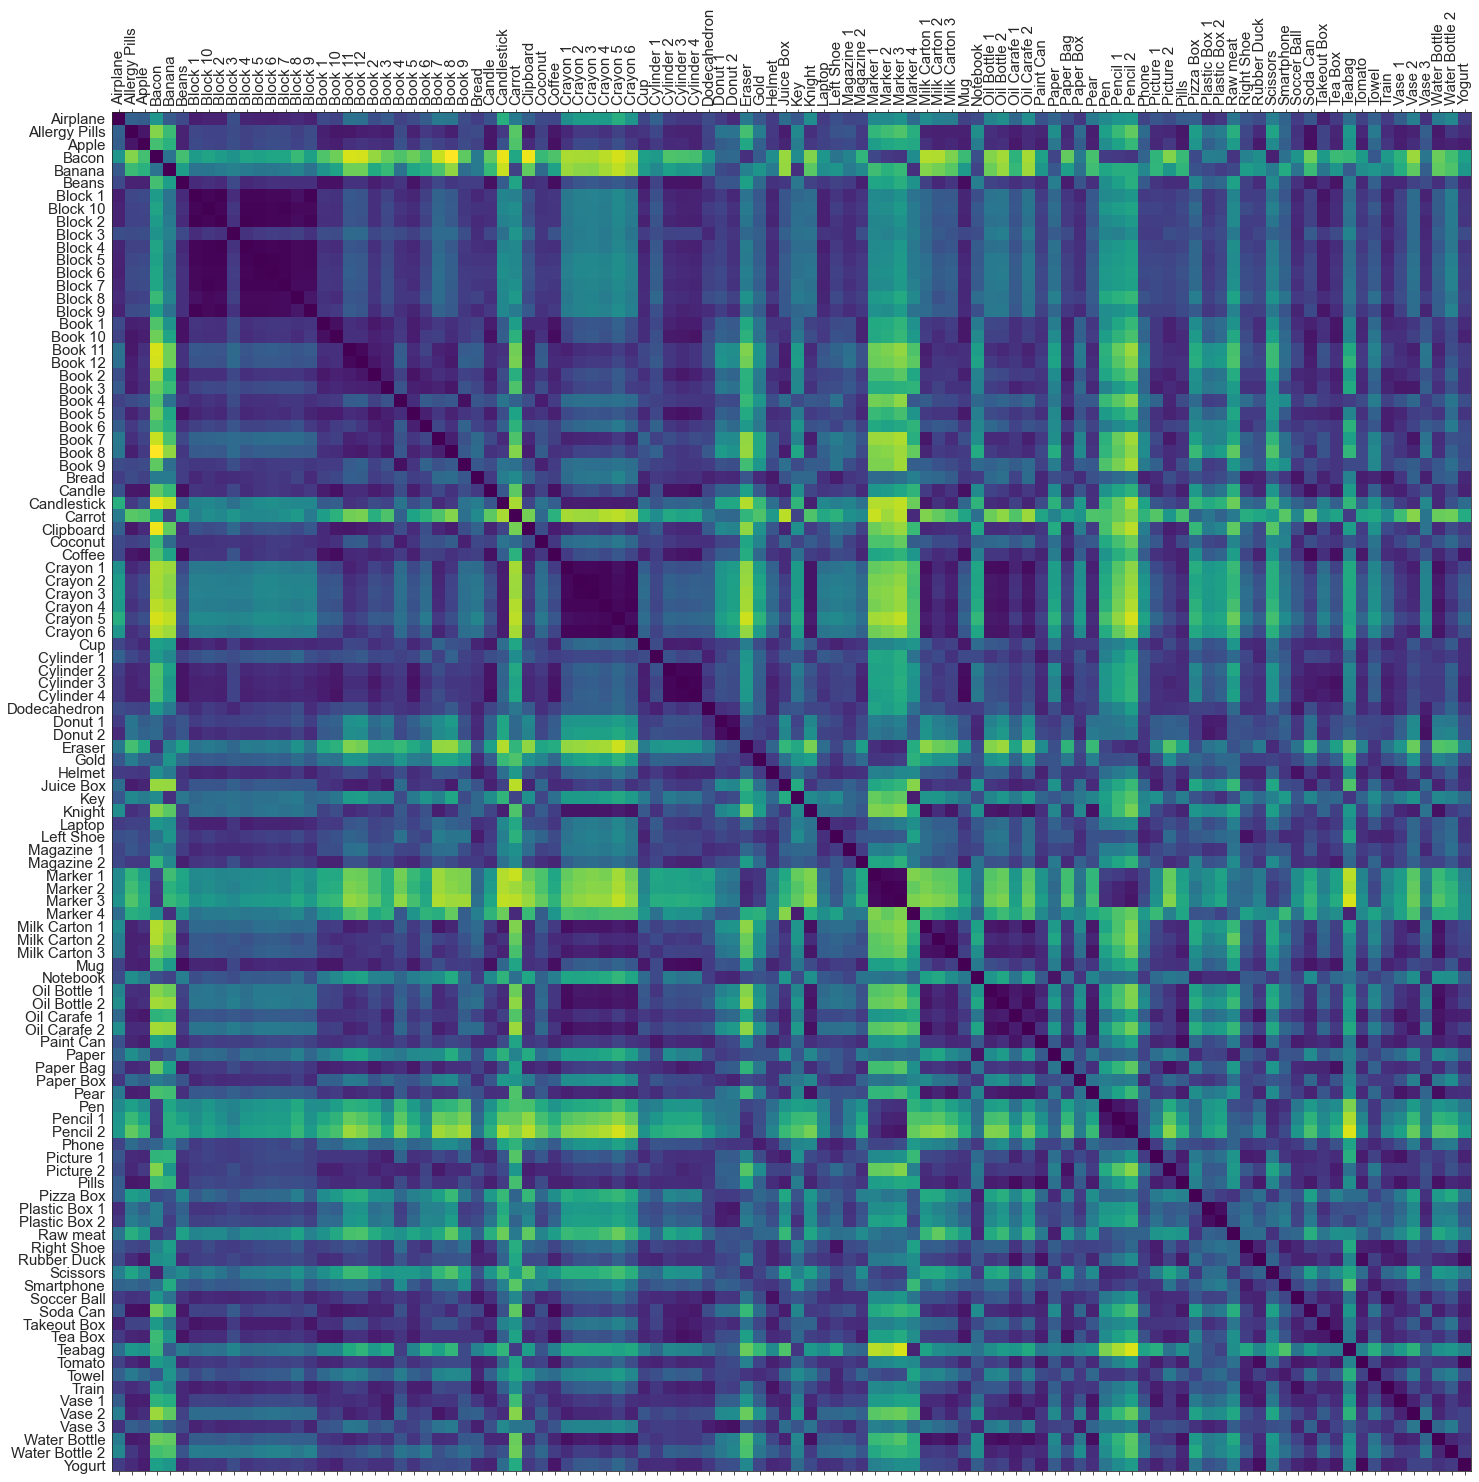

In [18]:
fig, ax = plt.subplots(figsize=(25,25))
# cax = ax.matshow(similarity_df.values, cmap='viridis', vmin=0, vmax=1000000)
cax = ax.matshow(similarity_df.values, cmap='viridis')
ax.set_xticks(np.arange(len(unique_objects)))
ax.set_xticklabels(unique_objects)
ax.set_yticks(np.arange(len(unique_objects)))
ax.set_yticklabels(unique_objects)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
# fig.colorbar(cax, ax=ax, orientation='horizontal')
plt.show()

### Fixated vs. non-fixated target similarity analysis.

This analysis asks whether, on a given trial, objects that were fixated were more similar to the target or not. 

In [19]:
D = []

n_fixated_objects = [] 
for p in all_participants:
    
    if False:
        verbose = True
    else: 
        verbose = False
    
    if verbose: 
        print(p)
    
    gaze_participant = gaze_objects[gaze_objects['participant'] == p]
    these_scenes = gaze_participant['scene'].unique()
    
    for s in these_scenes: 
          
        gaze_scene = gaze_participant[gaze_participant['scene'] == s]
        
        if len(gaze_scene):
            
            if verbose:
                print(s)
            
            # What objects could have been fixated? 
            possible_objects_in_scene = list(locations[locations['scene'] == s]['object'].values)
            
            # What objects were fixated? 
            fixated_objects_in_scene = list(np.unique(gaze_scene.dropna()['object']))
            fixated_objects_in_scene = [x for x in fixated_objects_in_scene if x in possible_objects_in_scene]
            was_fixated = [x in fixated_objects_in_scene for x in possible_objects_in_scene]
            
            # Compute similarity to target.
            target = gaze_scene['target'].values[0]
            distance_to_target = [sim_df_copy[sim_df_copy['object'] == o][target].values[0] for o in possible_objects_in_scene]
            
            # Put in dataframe, excluding target.
            d = {'participant': [p] * (len(possible_objects_in_scene)-1), 
                 'scene': [s] * (len(possible_objects_in_scene)-1),
                 'objects_in_scene': possible_objects_in_scene[1:],
                 'was_fixated': was_fixated[1:],
                 'distance_to_target': distance_to_target[1:]
            }
            
            D.append(pd.DataFrame(d))    
            
D = pd.concat(D)

mean fixated: 1.3566860764179467
SD fixated: 0.8797882708353874
mean non fixated: 1.5292847925144735
SD non fixated: 0.9715610575420108
DF: 171666
Ttest_indResult(statistic=-31.874030591424695, pvalue=2.7417924055979015e-222)


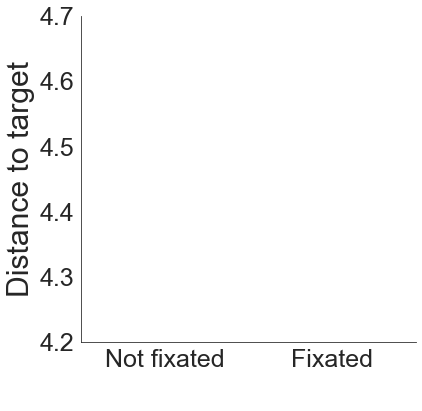

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
kwargs = {'alpha': 0.95}
sns.barplot(x="was_fixated", y="distance_to_target", data=D, ax=ax, **kwargs)
# ax.set_ylim((0.8,1.3)) # shape
# ax.set_ylim((1.7,2.2)) # color
# ax.set_ylim((1.2,1.7)) # shape and color
# ax.set_ylim((1.2,1.7)) # vgg block5
ax.set_ylim((4.2,4.7)) # vgg fc2
plt.setp(ax.get_xticklabels(), fontsize=25)
plt.setp(ax.get_yticklabels(), fontsize=25)
ax.set_xticklabels(['Not fixated', 'Fixated'])
change_width(ax, 0.5);
plt.xlabel(' ', fontsize=30);
plt.ylabel('Distance to target', fontsize=30);
sns.despine();
sns.set_style('white');

dist_fixated = D[D['was_fixated'] == True]['distance_to_target'].values
dist_not_fixated = D[D['was_fixated'] == False]['distance_to_target'].values

print('mean fixated: ' + str(np.mean(dist_fixated)))
print('SD fixated: ' + str(np.std(dist_fixated)))
print('mean non fixated: ' + str(np.mean(dist_not_fixated)))
print('SD non fixated: ' + str(np.std(dist_not_fixated)))
print('DF: ' + str(dist_fixated.shape[0] + dist_not_fixated.shape[0] - 2))
print(stats.ttest_ind(dist_fixated, dist_not_fixated))

if feature == 'VGG': 
    D['layer'] = layer
    D.to_csv('distance_fixated_notfixated_' + layer + '.csv', index=False)

In [21]:
if feature == 'VGG':

    layer_1 = pd.read_csv('distance_fixated_notfixated_block5_pool.csv')
    layer_2 = pd.read_csv('distance_fixated_notfixated_fc2.csv')
    df_layer_interaction = pd.concat([layer_1, layer_2])
    
    aov = pg.anova(dv='distance_to_target', between=['layer', 'was_fixated'], data=df_layer_interaction)
    pg.print_table(aov)


ANOVA SUMMARY

Source                       SS          DF          MS            F    p-unc      np2
-------------------  ----------  ----------  ----------  -----------  -------  -------
layer                742668.428       1.000  742668.428  1036239.018    0.000    0.751
was_fixated            1265.266       1.000    1265.266     1765.416    0.000    0.005
layer * was_fixated      53.137       1.000      53.137       74.141    0.000    0.000
Residual             246064.694  343332.000       0.717      nan      nan      nan



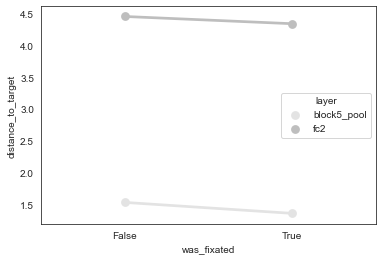

In [22]:
ax = sns.pointplot(x="was_fixated", y="distance_to_target", hue="layer", data=df_layer_interaction)

In [26]:
x = df_layer_interaction[(df_layer_interaction['layer'] == 'block5_pool') & (df_layer_interaction['was_fixated'] == False)]
y = df_layer_interaction[(df_layer_interaction['layer'] == 'block5_pool') & (df_layer_interaction['was_fixated'] == True)]
abs(x['distance_to_target'].mean() - y['distance_to_target'].mean())  

0.17259871609648858

In [28]:
x = df_layer_interaction[(df_layer_interaction['layer'] == 'fc2') & (df_layer_interaction['was_fixated'] == False)]
y = df_layer_interaction[(df_layer_interaction['layer'] == 'fc2') & (df_layer_interaction['was_fixated'] == True)]

In [29]:
abs(x['distance_to_target'].mean() - y['distance_to_target'].mean())  

0.11388877005140685